In [1]:
import os
import glob
import cv2
import pydicom as dicom
import plistlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [2]:
def saveImages(dicomFilePath, saveFolderPath):
    """
    Saving dicom images as png

    Parameters
    ---------- 
    dicomFilePath : str
        Dicom File Path
    saveFolderPath : str
        Image Save Folder Path
    
    Returns
    -------
    
    imageFilePath: str
        Saved Image File Path
        
    """
    
    dicomData = dicom.read_file(dicomFilePath)
    imgArray = dicomData.pixel_array
    imgArray = 255*((imgArray - imgArray.min()) / (imgArray.max() - imgArray.min()))
    imgArray = imgArray.astype(np.uint8)
    imgArray = Image.fromarray(imgArray).convert("L")
    
    dicomFileName = dicomFilePath.split(os.path.sep)[-1]
    patientID = '_'.join(dicomFileName.split("_")[:2])
    view = ''.join(dicomFileName.split("_")[3:5])
    
    imageFileName = '_'.join([patientID, view]) + '.png'
    
    imageFilePath = os.path.join(saveFolderPath, imageFileName)
    imgArray.save(imageFilePath)
    
    return imageFilePath


def loadPoint(point_string):
    x, y = tuple([float(num) for num in point_string.strip('()').split(',')])
    return y, x

            
def saveMaskAsTxt(xmlFilePath, imageFilePath, saveMaskPath, biradsScore, imshape):
    
    """
    Saving mask informations to text file

    Parameters
    ---------- 
    xmlFilePath : str
        XML File Path
    imageFilePath : str
        Image File Path
    saveMaskPath : str
        Save Mask File Path
    biradsScore : int
        Malignancy-Benignance or Mass
    imshape : tupple
        Image Shape
    Returns
    -------
    
    """
    
    with open(xmlFilePath, 'rb') as maskFile:
        plistDict = plistlib.load(maskFile, fmt=plistlib.FMT_XML)['Images'][0]
        
    pngFileName = imageFilePath.split(os.path.sep)[-1] 
    
    rois = plistDict['ROIs']
    maskCounter = 0
    maskPoints = []
    abnormalities = []
    for roi in rois:
        maskCounter += 1
        numPoints = roi['NumberOfPoints']
        if numPoints == 1:
            maskCounter -= 1
            continue
        
        abnormality = roi["Name"]
        abnormalities.append(abnormality)
                        
        if abnormality =="Mass":
            
            points = roi['Point_px']
            points = [loadPoint(point) for point in points]
            
            points = np.array(points)
            xmin = int(min(points[:,1]))
            ymin = int(min(points[:,0]))
            xmax = int(max(points[:,1]))
            ymax = int(max(points[:,0]))

            maskPoints.append(' '.join([str(xmin), str(ymin), str(xmax), str(ymax), str(biradsScore)]))

        else:
            maskCounter-=1
            continue
    
        lines = [pngFileName, ' '.join(map(str, imshape)), str(maskCounter)]
        
    if maskPoints:
        for maskPoint in maskPoints:
            lines.append(maskPoint)

        with open(saveMaskPath, 'a') as textFile:
            textFile.write('#\n')
            textFile.write('\n'.join(lines))
            textFile.write('\n')

In [6]:
dataFolderPath = '' # SET INbreast FOLDER PATH
saveFolderPath = '' # SET Which Folder to Save
kFoldSplit = 5 # SET K-FOLD Validation
massClassification = False # SET False for Mass Class, SET True for Malign-Benign Classes

In [7]:
'''Loading XML files and reading DataFrame'''
xmlFiles = sorted(glob.glob(os.path.join(dataFolderPath, 'AllXML', '*')))
df = pd.read_excel(os.path.join(dataFolderPath, 'INbreast.xls'))
df

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,Mass,Micros,Distortion,Asymmetry,Findings Notes (in Portuguese),Other Notes,Lesion Annotation Status,Pectoral Muscle Annotation,Other Annotations
0,removed,removed,R,CC,201001.0,22678622.0,4,1,NaN,NaN,NaN,NaN,normal,NaN,No annotation (Normal),NaN,NaN
1,removed,removed,L,CC,201001.0,22678646.0,4,3,X,NaN,NaN,NaN,nódulo,NaN,NaN,NaN,NaN
2,removed,removed,R,MLO,201001.0,22678670.0,4,1,NaN,NaN,NaN,NaN,normal,NaN,No annotation (Normal),NaN,NaN
3,removed,removed,L,MLO,201001.0,22678694.0,4,3,X,NaN,NaN,NaN,nódulo,NaN,NaN,NaN,NaN
4,removed,removed,R,CC,201001.0,22614074.0,2,5,X,X,NaN,NaN,nódulo QSE + micros,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,removed,removed,R,MLO,200802.0,24055752.0,4,2,NaN,X,NaN,NaN,micros,NaN,NaN,NaN,NaN
408,removed,removed,L,CC,200802.0,24055779.0,4,2,NaN,X,NaN,NaN,micros,NaN,NaN,NaN,NaN
409,removed,removed,R,CC,200802.0,24055806.0,4,2,NaN,X,NaN,NaN,micros,NaN,NaN,NaN,NaN
410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
'''Filtering rows where "File Name" column is not NaN'''
df = df[df['File Name'].notna()]
df['File Name'] = df['File Name'].astype('int') # sorgu islemini kolaylastirabilmek icin float olarak tutulmasi gerek yok

/tmp/ipykernel_33959/426763245.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['File Name'] = df['File Name'].astype('int') # sorgu islemini kolaylastirabilmek icin float olarak tutulmasi gerek yok


In [9]:
'''Reading XML files and finding mass filenames'''
massFileNames = []
for xmlFile in xmlFiles:
    with open(xmlFile, 'rb') as maskFile:
        plistDict = plistlib.load(maskFile, fmt=plistlib.FMT_XML)['Images'][0]
        
    rois = plistDict['ROIs']
    
    abnormalities = []
    
    for roi in rois:
        numPoints = roi['NumberOfPoints']
        if numPoints == 1:
            continue

        abnormality = roi["Name"]
        abnormalities.append(abnormality)
    
    if 'Mass' in abnormalities:
        massFileNames.append(xmlFile.split(os.path.sep)[-1].split('.')[0])

In [10]:
'''Using mass filenames and filtering mass patients'''
massDicomFilePaths = [glob.glob(os.path.join(dataFolderPath, 'AllDICOMs', str(filename) + '*.dcm'))[0] for filename in massFileNames]
massPatients = [massDicomFilePath.split(os.path.sep)[-1].split('_')[1] for massDicomFilePath in massDicomFilePaths]
massPatients = list(set(massPatients))

In [11]:
'''Applying 5 Fold Cross Validation Based on Mass Patients'''
kf = KFold(n_splits=kFoldSplit, shuffle=True, random_state=9)
patientFolds = []
for trainIndex, valIndex in kf.split(massPatients):
    trainPatients = []
    for i in range(len(trainIndex)):
        trainPatients.append(massPatients[trainIndex[i]])
    testPatients = []
    for i in range(len(valIndex)):
        testPatients.append(massPatients[valIndex[i]])
    patientFolds.append([trainPatients,testPatients])

In [12]:
'''Creates folders and saves images as png and their mask information to annotation text file '''
for i in tqdm_notebook(range(len(patientFolds))):
    trainPatients = patientFolds[i][0]
    testPatients = patientFolds[i][1]
    
    foldPath = os.path.join(saveFolderPath, 'Fold' + str(i))
    if not os.path.exists(foldPath):
        os.mkdir(foldPath)
    
    trainFoldPath = os.path.join(foldPath, 'train')
    if not os.path.exists(trainFoldPath):
        os.mkdir(trainFoldPath)

    validationFoldPath = os.path.join(foldPath, 'validation')
    if not os.path.exists(validationFoldPath):
        os.mkdir(validationFoldPath)
    
    saveMaskTextPath = os.path.join(foldPath, 'annotation_Train.txt')
    if not os.path.exists(saveMaskTextPath):
        f = open(saveMaskTextPath, "x")
    
    for trainPatient in tqdm_notebook(trainPatients, desc='Train Patients'):
        trainPatientFilePaths = glob.glob(os.path.join(dataFolderPath, 'AllDICOMs', '*' + str(trainPatient) + '*.dcm'))

        for trainPatientFilePath in trainPatientFilePaths:
            patientFileName = trainPatientFilePath.split(os.path.sep)[-1].split('_')[0]
            
            if patientFileName in massFileNames:
                
                xmlFilePath = os.path.join(dataFolderPath, 'AllXML', patientFileName + '.xml')
                if massClassification:
                    biradsScore = df[df['File Name']==int(patientFileName)]['Bi-Rads'].values[0]
                else:
                    biradsScore = 0
                imageFilePath = saveImages(trainPatientFilePath, trainFoldPath)
                saveMaskPath = os.path.join(trainFoldPath, imageFilePath.split(os.path.sep)[-1].split('.')[0])
                imshape = Image.open(imageFilePath).size
                saveMaskAsTxt(xmlFilePath, imageFilePath, saveMaskTextPath, biradsScore, imshape)
                
    saveMaskTextPath = os.path.join(foldPath, 'annotation_Validation.txt')
    if not os.path.exists(saveMaskTextPath):
        f = open(saveMaskTextPath, "x")
                
    for validationPatient in tqdm_notebook(testPatients, desc='Validation Patients'):
        validationPatientFilePaths = glob.glob(os.path.join(dataFolderPath, 'AllDICOMs', '*' + str(validationPatient) + "*.dcm"))

        for validationPatientFilePath in validationPatientFilePaths:
            patientFileName = validationPatientFilePath.split(os.path.sep)[-1].split('_')[0]
            if patientFileName in massFileNames:
                
                xmlFilePath = os.path.join(dataFolderPath, 'AllXML', patientFileName + '.xml')
                if massClassification:
                    biradsScore = df[df['File Name']==int(patientFileName)]['Bi-Rads'].values[0]
                else:
                    biradsScore = 0
                imageFilePath = saveImages(validationPatientFilePath, validationFoldPath)
                saveMaskPath = os.path.join(validationFoldPath, imageFilePath.split(os.path.sep)[-1].split('.')[0])
                imshape = Image.open(imageFilePath).size
                saveMaskAsTxt(xmlFilePath, imageFilePath, saveMaskTextPath, biradsScore, imshape)

  0%|          | 0/5 [00:00<?, ?it/s]

Train Patients:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Patients:   0%|          | 0/10 [00:00<?, ?it/s]

Train Patients:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Patients:   0%|          | 0/10 [00:00<?, ?it/s]

Train Patients:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Patients:   0%|          | 0/10 [00:00<?, ?it/s]

Train Patients:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Patients:   0%|          | 0/10 [00:00<?, ?it/s]

Train Patients:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Patients:   0%|          | 0/10 [00:00<?, ?it/s]

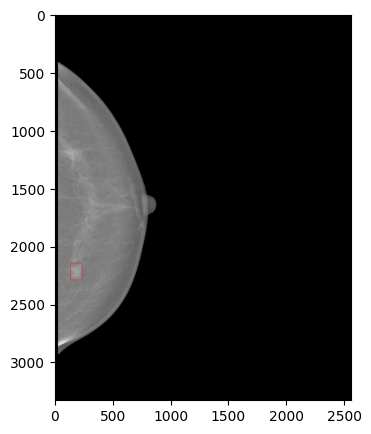

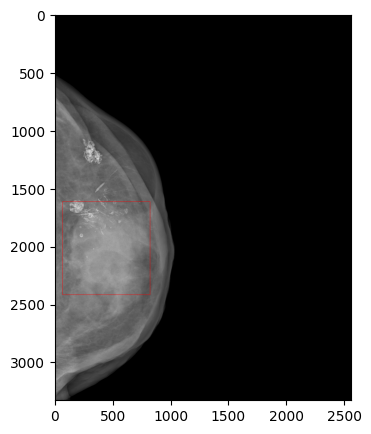

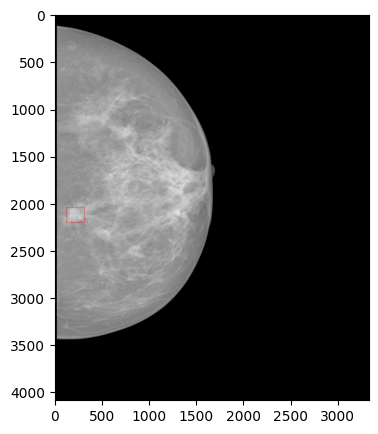

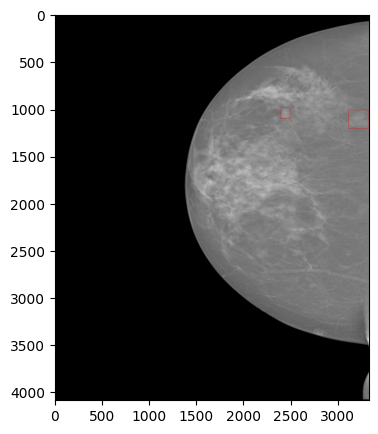

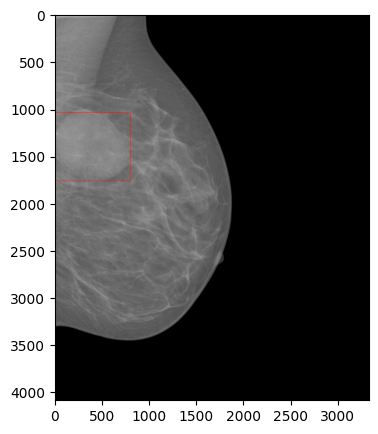

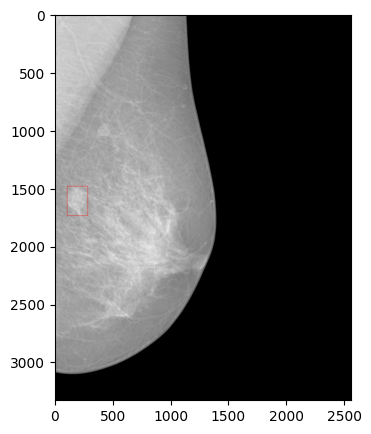

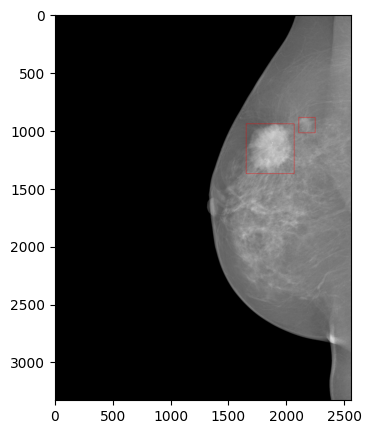

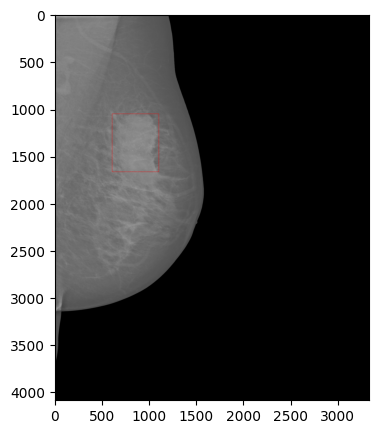

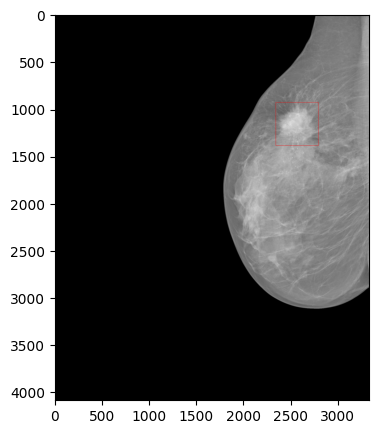

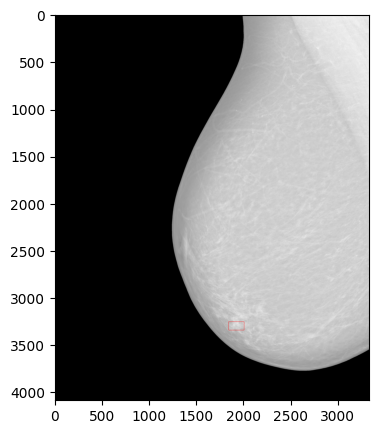

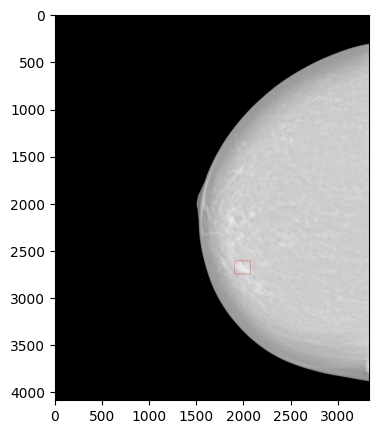

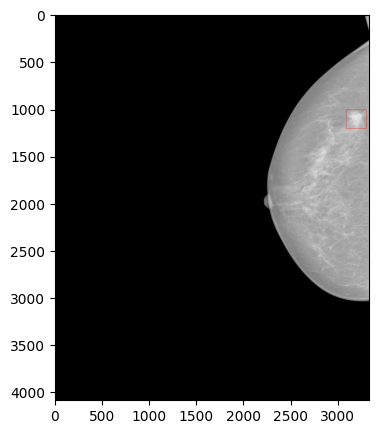

IndexError: list index out of range

In [14]:
'''Visualizing Data with Annotations'''
foldNum = 0
annotationFilePath = os.path.join(saveFolderPath, 'Fold' + str(foldNum), 'annotation_Validation.txt')

colors = [(255,0,0), (0,255,0)]

dataCursorIndex = 0
with open(annotationFilePath, 'r') as f:
    data = f.readlines()

while True:
    if data[dataCursorIndex] == '#\n':
        dataCursorIndex+=1
        fileName = data[dataCursorIndex].split('\n')[0]
        validationImagePath = os.path.join(saveFolderPath, 'Fold' + str(foldNum), 'validation', fileName)
        
        plt.figure(figsize=(5,5))
        image = cv2.imread(validationImagePath)
        dataCursorIndex+=2
        massCount = int(data[dataCursorIndex])
        dataCursorIndex+=1
        
        for massCounter in range(massCount):
            boxCoordinates = data[dataCursorIndex].split()
            cv2.rectangle(image, (int(boxCoordinates[0]), int(boxCoordinates[1])), (int(boxCoordinates[2]), int(boxCoordinates[3])), color=colors[int(boxCoordinates[-1])], thickness=2)
            dataCursorIndex+=1
            
        dataCursorIndex+=1
        plt.imshow(image)
        plt.pause(0.05)
    else:
        dataCursorIndex+=2
        massCount = int(data[dataCursorIndex])
        dataCursorIndex += massCount + 1
    if dataCursorIndex == len(data):
        break